# GPT-J addition
- Follow Neel Nanda's real time research [video](https://www.youtube.com/watch?v=OI1we2bUseI&list=PL7m7hLIqA0hr4dVOgjNwP2zjQGVHKeB7T&index=4)

- Follow this [code base](https://github.com/neelnanda-io/Understanding-Arithmetic/blob/main/scratch.py)

In [160]:
import os
import transformer_lens
from transformer_lens import HookedTransformer
from transformer_lens import utils

import torch
import plotly
import plotly.express as px
import einops
import numpy as np


In [2]:
SEED = 42
torch.set_grad_enabled(False)

In [3]:
model: HookedTransformer = HookedTransformer.from_pretrained("gpt-j", device="cpu")
model: HookedTransformer = model.to(torch.bfloat16).to("cuda") # use torch.bfloat16 to save memory


C:\Users\buzlab\.conda\envs\llmtt\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loaded pretrained model gpt-j into HookedTransformer
Changing model dtype to torch.bfloat16
Moving model to device:  cuda


In [4]:
print("free(Gb):", torch.cuda.mem_get_info()[0]/1000000000, ",total(Gb):", torch.cuda.mem_get_info()[1]/1000000000)

free(Gb): 0.0 ,total(Gb): 11.81089792


In [5]:
n_layers = model.cfg.n_layers
d_model = model.cfg.d_model
n_heads = model.cfg.n_heads
d_head = model.cfg.d_head
d_mlp = model.cfg.d_mlp
d_vocab = model.cfg.d_vocab

# Number Tokenization

In [6]:
print(model.to_str_tokens("23481762358723658732568235"))
print(model.to_str_tokens("123+456=579"))
print(model.to_str_tokens("123+456=579\n913+72=985\n218+276=494"))

['<|endoftext|>', '23', '48', '176', '23', '587', '23', '658', '73', '25', '68', '235']
['<|endoftext|>', '123', '+', '456', '=', '579']
['<|endoftext|>', '123', '+', '456', '=', '579', '\n', '9', '13', '+', '72', '=', '985', '\n', '218', '+', '276', '=', '494']


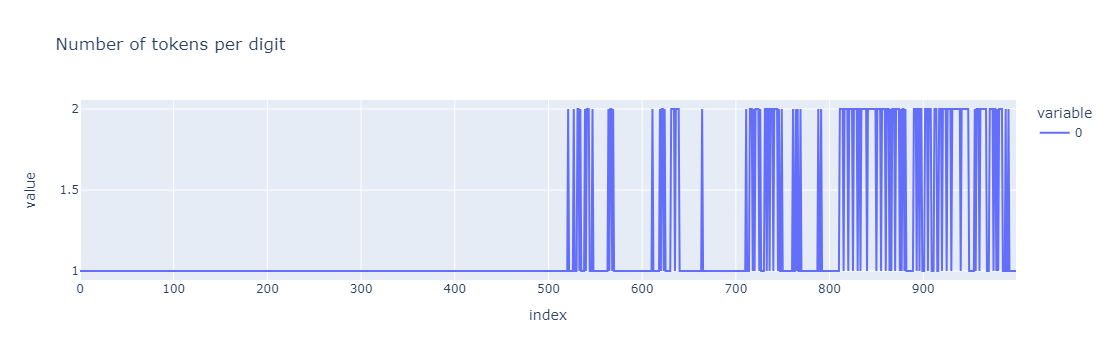

In [12]:
num_tokens_per_digit = [len(model.to_str_tokens(str(i), prepend_bos=False)) for i in range(1000)]
px.line(num_tokens_per_digit, title="Number of tokens per digit")


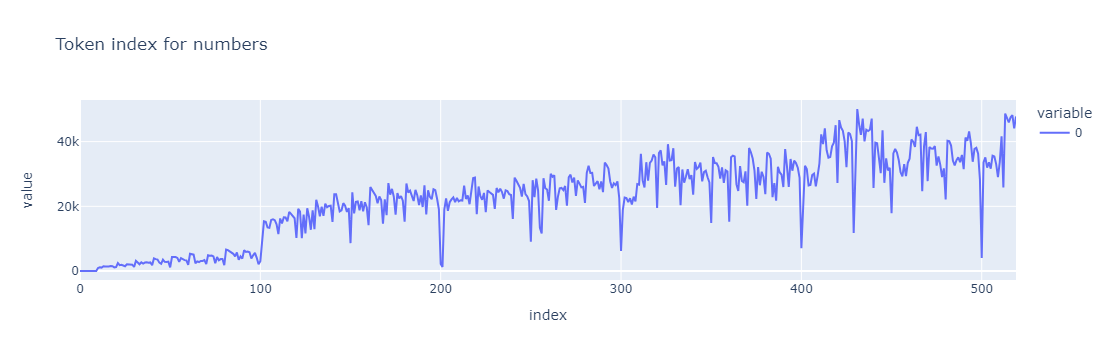

In [38]:
single_token_numbers = torch.arange(520)
number_token_index = torch.tensor([model.to_single_token(str(i)) for i in single_token_numbers])
px.line(number_token_index, title="Token index for numbers")

# Number Token Embedding

### From 0 to about 520

In [62]:
number_embeddings = model.W_E[number_token_index].float()
i_am_a_number = number_embeddings.mean(0)
number_embeddings_centered = number_embeddings - i_am_a_number
U, S, Vh = number_embeddings_centered.svd()


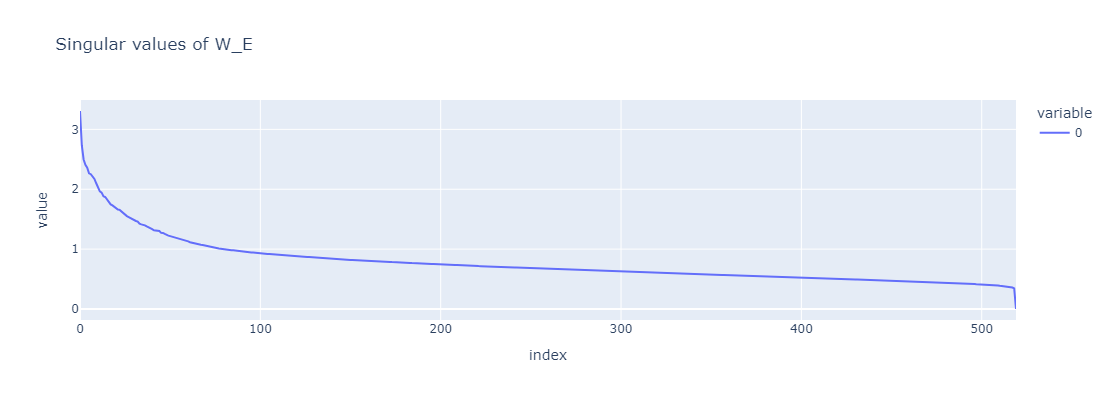

In [63]:
px.line(S.cpu(), title="Singular values of W_E",width=400, height=400)


In [50]:
(U[:, :20].cpu()).shape

torch.Size([520, 20])

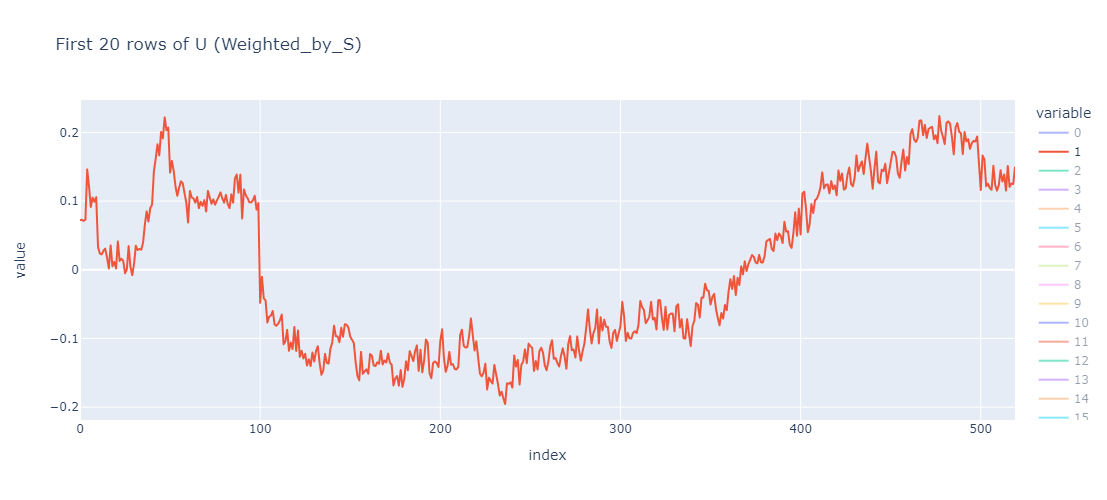

In [58]:
# double click on the vairalbe to only show that variable
px.line((U[:, :20].cpu()) * S[:20, None].T.cpu(), title="First 20 rows of U (Weighted_by_S)",width=500, height=500)

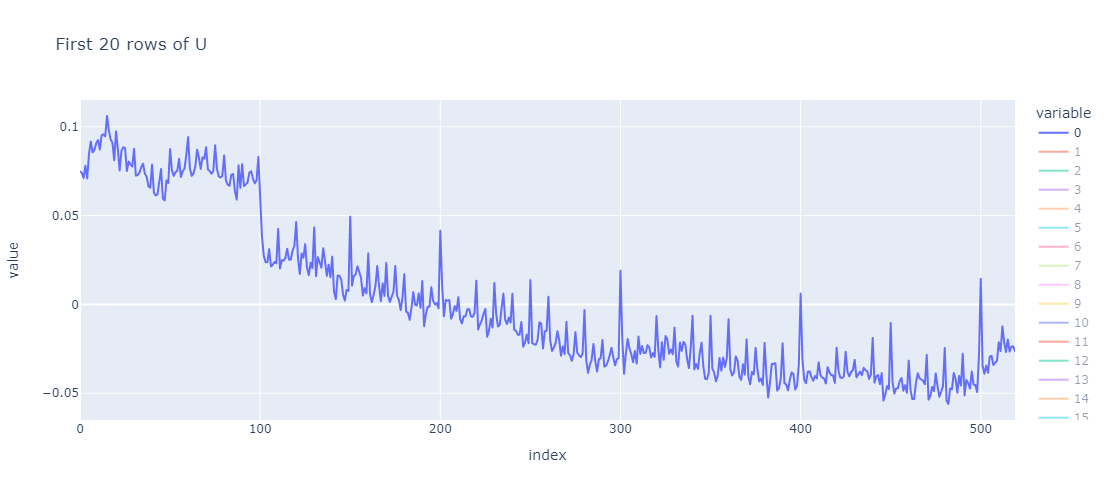

In [60]:
px.line(U[:, :20].cpu(), title="First 20 rows of U",width=500, height=500)


### From 100 to about 520

In [64]:
number_embeddings = model.W_E[number_token_index[100:]].float()
i_am_a_number = number_embeddings.mean(0)
number_embeddings_centered = number_embeddings - i_am_a_number
U, S, Vh = number_embeddings_centered.svd()


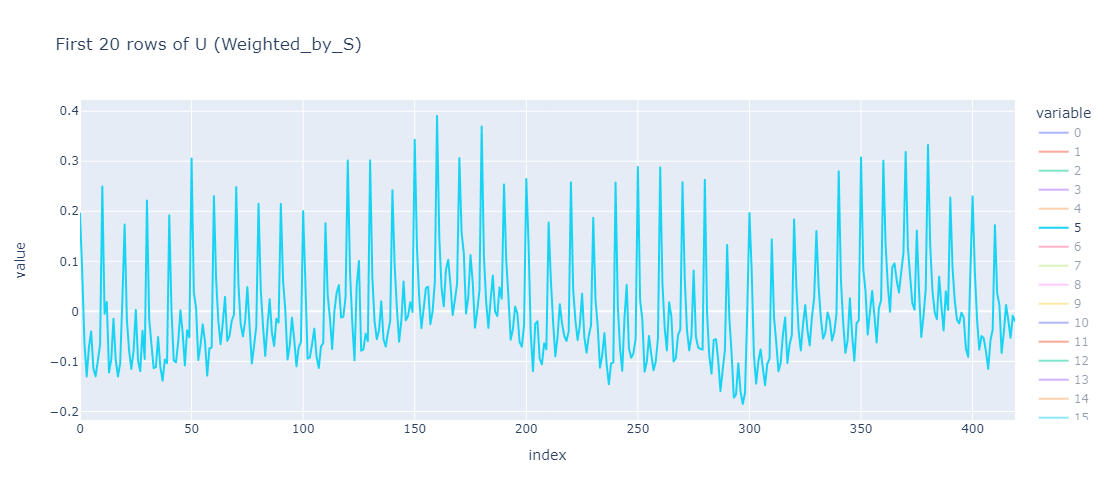

In [65]:
# double click on the vairalbe to only show that variable
px.line((U[:, :20].cpu()) * S[:20, None].T.cpu(), title="First 20 rows of U (Weighted_by_S)",width=500, height=500)

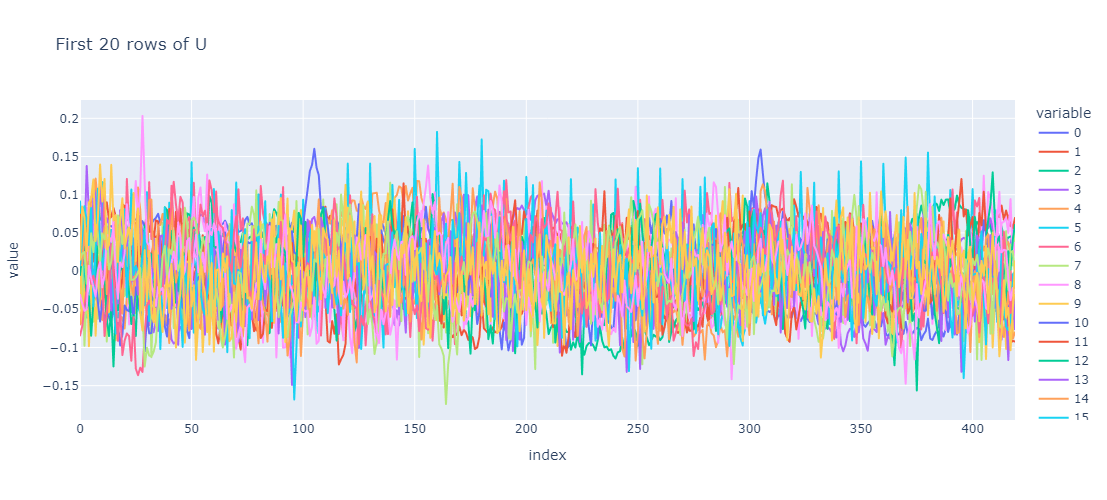

In [66]:
px.line(U[:, :20].cpu(), title="First 20 rows of U",width=500, height=500)


### Only take the number that are multiply of 10

In [76]:
by_digit = einops.rearrange(number_embeddings_centered, "(other ten) d_model -> other ten d_model", ten=10)
U2, S2, Vh2 = by_digit.mean(0).svd()


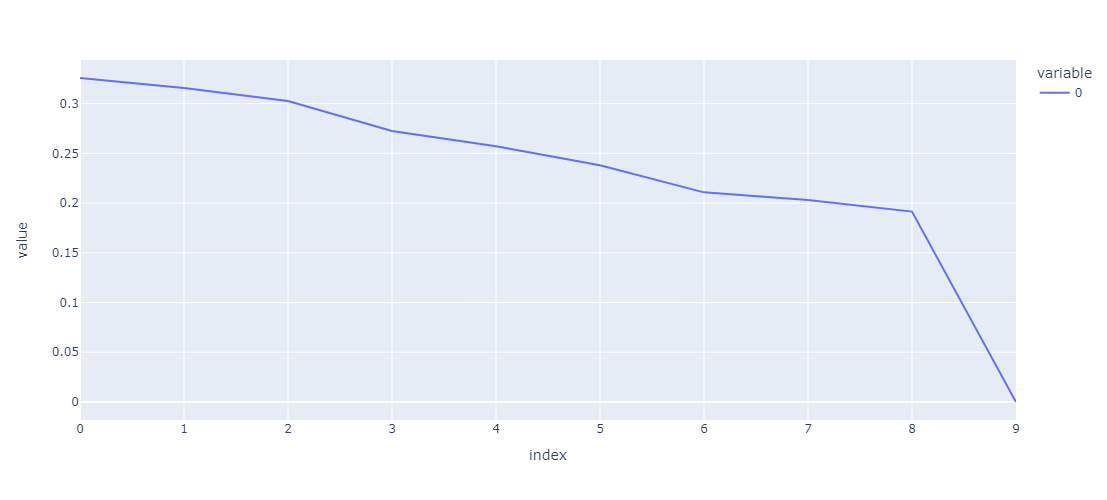

In [77]:
px.line(S2.cpu(),width=500, height=500)


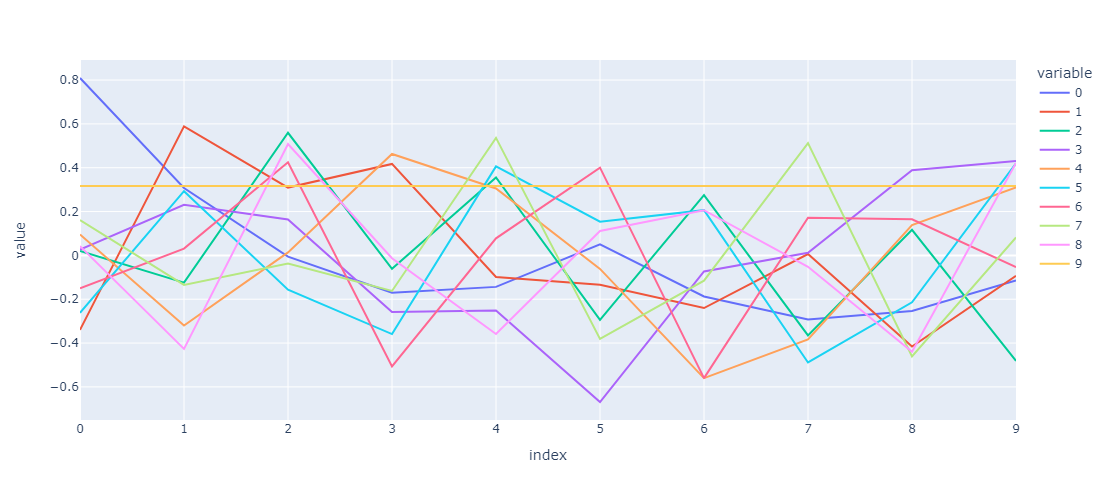

In [78]:
px.line(U2.cpu(),width=500, height=500)


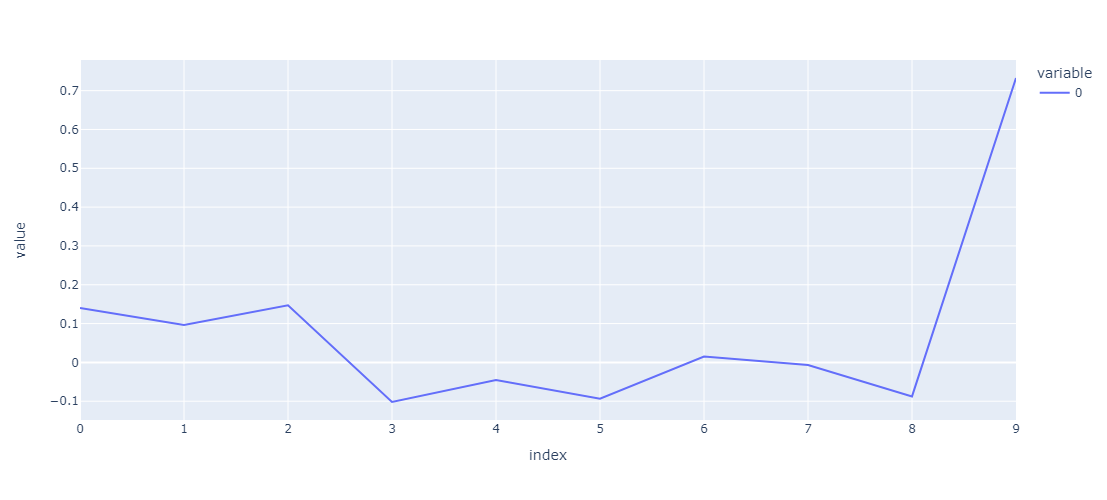

In [83]:
px.line(U2.T.cpu() @ S2[:, None].cpu(),width=500,height=500)


# Fourier Basis

In [85]:
def fourier_basis(n):
    terms = []
    labels = []
    terms.append(torch.ones(n))
    labels.append("const")
    for i in range(1, n//2):
        terms.append(torch.cos(torch.arange(n) * 2 * torch.pi / n * i))
        terms.append(torch.sin(torch.arange(n) * 2 * torch.pi / n * i))
        labels.append(f"cos_{i}")
        labels.append(f"sin_{i}")
    if n%2 == 0:
        terms.append(torch.tensor([(1 if j%2==0 else -1) for j in range(n)]))
        labels.append(f"sign")
    terms = torch.stack(terms)
    terms = terms / terms.norm(dim=-1, keepdim=True)
    return terms.cuda(), labels

fourier_terms, fourier_labels = fourier_basis(10)

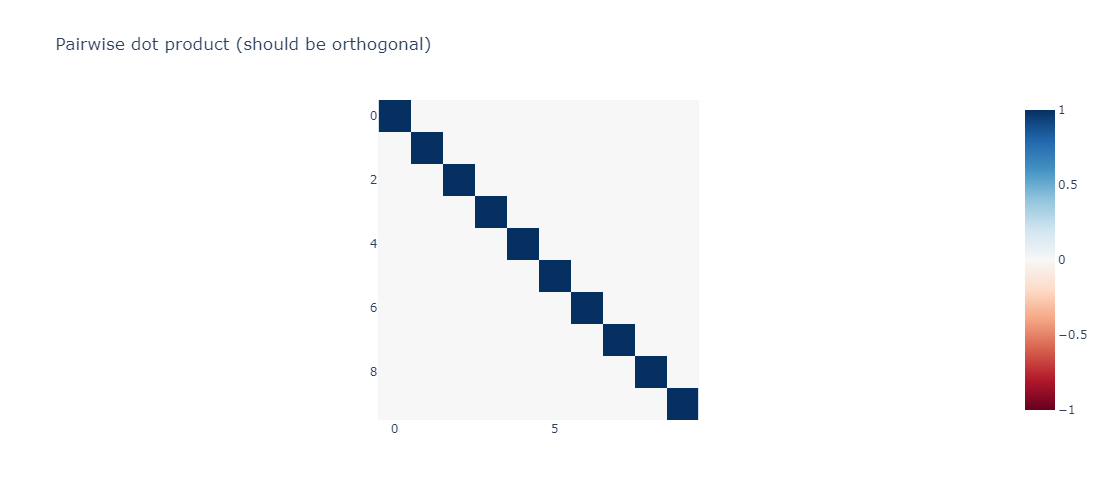

In [90]:
px.imshow(fourier_terms.cpu() @ fourier_terms.T.cpu(),
          title="Pairwise dot product (should be orthogonal)",
          color_continuous_scale="RdBu",
          zmin=-1, zmax=1,
          width=500,height=500)


##### MOTIVATION; take the singular vector and do Fourier transform on them, do they look interesting?

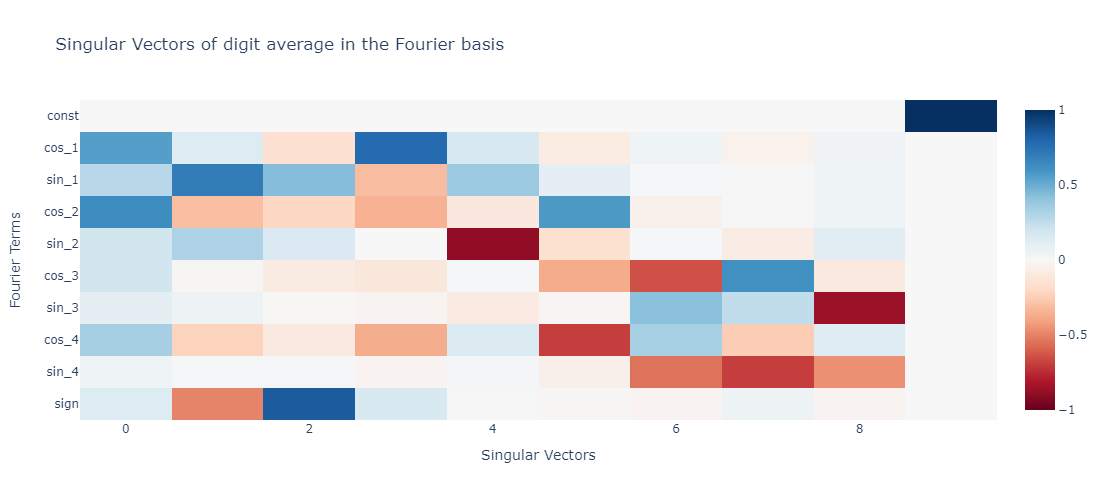

In [97]:
px.imshow(fourier_terms.cpu() @ U2.cpu(),y=fourier_labels,
          labels=dict(x="Singular Vectors", y="Fourier Terms"),
          title="Singular Vectors of digit average in the Fourier basis",
          color_continuous_scale="RdBu",
          zmin=-1, zmax=1,
          width=500,height=500)


# Prompt Set UP

In [104]:
def make_zero_shot_prompt(num_prompts=10, range_nums=(100, 200)):
    x = np.random.randint(*range_nums, size=(num_prompts))
    y = np.random.randint(*range_nums, size=(num_prompts))
    z = x+y
    prompts = [f"{x[i]}+{y[i]}=" for i in range(num_prompts)]
    answers = [f"{z[i]}" for i in range(num_prompts)]
    return prompts, answers, torch.tensor(x, device="cuda"), torch.tensor(y, device="cuda"), torch.tensor(z, device="cuda")



In [105]:
def make_n_shot_prompt(num_prompts=10, num_shots=2, range_nums=(100, 200), seed=42):
    np.random.seed(seed) # important to have seed!
    full_prompts = [""] * num_prompts
    for i in range(num_shots):
        p, a, _, _, _ = make_zero_shot_prompt(num_prompts, range_nums)
        for j in range(num_prompts):
            full_prompts[j] = full_prompts[j] + f"{p[j]}{a[j]}\n"
    prompts, answers, x, y, z = make_zero_shot_prompt(num_prompts, range_nums)
    full_prompts = [f"{full_prompts[i]}{prompts[i]}" for i in range(num_prompts)]
    return full_prompts, prompts, answers, x, y, z



In [106]:
num_prompts = 256
num_shot = 2
full_prompts, prompts, answers, x, y, z = make_n_shot_prompt(num_prompts, num_shot)
print(full_prompts, prompts, answers, x, y, z)


['151+179=330\n161+116=277\n161+101=', '192+192=384\n168+172=340\n161+106=', '114+102=216\n175+132=307\n193+181=', '171+119=290\n115+183=298\n194+190=', '160+158=318\n189+176=365\n123+133=', '120+135=255\n189+191=380\n154+190=', '182+118=300\n147+128=275\n108+116=', '186+189=375\n184+112=296\n102+142=', '174+166=340\n138+145=283\n130+158=', '174+118=292\n199+134=333\n139+150=', '187+119=306\n132+105=237\n135+153=', '199+195=394\n193+181=374\n123+123=', '123+170=293\n122+168=290\n194+124=', '102+151=253\n109+146=255\n105+170=', '121+132=253\n168+124=292\n165+151=', '152+139=291\n199+165=364\n183+169=', '101+138=239\n133+109=242\n191+187=', '187+181=368\n151+155=306\n174+132=', '129+100=229\n194+129=323\n103+148=', '137+110=247\n109+104=213\n178+128=', '101+191=292\n118+132=250\n105+162=', '163+156=319\n157+164=321\n193+121=', '159+188=347\n195+117=312\n150+125=', '120+149=269\n100+195=295\n161+127=', '132+122=254\n168+148=316\n156+184=', '175+130=305\n103+110=213\n165+148=', '157+193=35

#### Run with Cache

In [107]:
tokens = model.to_tokens(full_prompts)
print("tokens.shape", tokens.shape)
logits, cache = model.run_with_cache(tokens)


tokens.shape torch.Size([256, 17])


#### Plot log probablitity

In [146]:
log_probs = logits.log_softmax(dim=-1)
answer_tokens = torch.tensor([model.to_single_token(a) for a in answers]).cuda()
plps = (log_probs[torch.arange(num_prompts).cuda(), -1, answer_tokens])

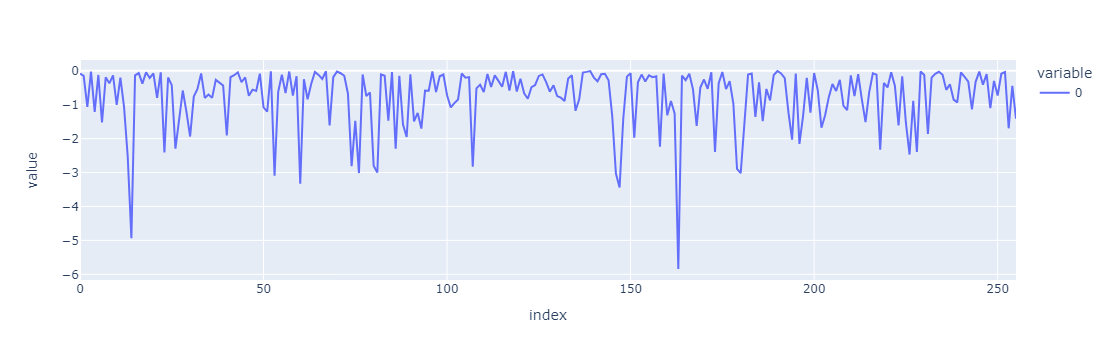

In [197]:
plps_f = plps.float()
plps_np = plps_f.detach().cpu().numpy()
px.line(plps_np[:])


#### Investigate the error

In [203]:
utils.test_prompt(full_prompts[163],answers[163],model,prepend_space_to_answer=True)

Tokenized prompt: ['<|endoftext|>', '193', '+', '106', '=', '299', '\n', '107', '+', '104', '=', '211', '\n', '196', '+', '172', '=']
Tokenized answer: [' 368']


Performance on answer token:
Rank: 99       Logit: 11.38 Prob:  0.00% Token: | 368|

Top 0th token. Logit: 23.38 Prob: 91.80% Token: |348|
Top 1th token. Logit: 19.38 Prob:  1.68% Token: |248|
Top 2th token. Logit: 19.12 Prob:  1.31% Token: |448|
Top 3th token. Logit: 19.00 Prob:  1.15% Token: |148|
Top 4th token. Logit: 18.38 Prob:  0.62% Token: |338|
Top 5th token. Logit: 18.38 Prob:  0.62% Token: |328|
Top 6th token. Logit: 18.25 Prob:  0.55% Token: |548|
Top 7th token. Logit: 17.62 Prob:  0.29% Token: |368|
Top 8th token. Logit: 17.25 Prob:  0.20% Token: |748|
Top 9th token. Logit: 17.12 Prob:  0.18% Token: |228|


Ranks of the answer tokens: [(' 368', 99)]

In [202]:
utils.test_prompt(full_prompts[163],answers[163],model,prepend_space_to_answer=False)

Tokenized prompt: ['<|endoftext|>', '193', '+', '106', '=', '299', '\n', '107', '+', '104', '=', '211', '\n', '196', '+', '172', '=']
Tokenized answer: ['368']


Performance on answer token:
Rank: 7        Logit: 17.62 Prob:  0.29% Token: |368|

Top 0th token. Logit: 23.38 Prob: 91.80% Token: |348|
Top 1th token. Logit: 19.38 Prob:  1.68% Token: |248|
Top 2th token. Logit: 19.12 Prob:  1.31% Token: |448|
Top 3th token. Logit: 19.00 Prob:  1.15% Token: |148|
Top 4th token. Logit: 18.38 Prob:  0.62% Token: |338|
Top 5th token. Logit: 18.38 Prob:  0.62% Token: |328|
Top 6th token. Logit: 18.25 Prob:  0.55% Token: |548|
Top 7th token. Logit: 17.62 Prob:  0.29% Token: |368|
Top 8th token. Logit: 17.25 Prob:  0.20% Token: |748|
Top 9th token. Logit: 17.12 Prob:  0.18% Token: |228|


Ranks of the answer tokens: [('368', 7)]

In [204]:
utils.test_prompt(full_prompts[14],answers[14],model,prepend_space_to_answer=False)

Tokenized prompt: ['<|endoftext|>', '121', '+', '132', '=', '253', '\n', '168', '+', '124', '=', '292', '\n', '165', '+', '151', '=']
Tokenized answer: ['316']


Performance on answer token:
Rank: 3        Logit: 18.62 Prob:  0.72% Token: |316|

Top 0th token. Logit: 23.50 Prob: 94.14% Token: |326|
Top 1th token. Logit: 19.62 Prob:  1.95% Token: |336|
Top 2th token. Logit: 19.38 Prob:  1.53% Token: |226|
Top 3th token. Logit: 18.62 Prob:  0.72% Token: |316|
Top 4th token. Logit: 18.50 Prob:  0.63% Token: |236|
Top 5th token. Logit: 17.25 Prob:  0.18% Token: | 326|
Top 6th token. Logit: 16.75 Prob:  0.11% Token: |136|
Top 7th token. Logit: 16.50 Prob:  0.09% Token: |416|
Top 8th token. Logit: 16.38 Prob:  0.08% Token: |426|
Top 9th token. Logit: 16.12 Prob:  0.06% Token: |327|


Ranks of the answer tokens: [('316', 3)]

#### Log probality of the correct VS incorrect answer

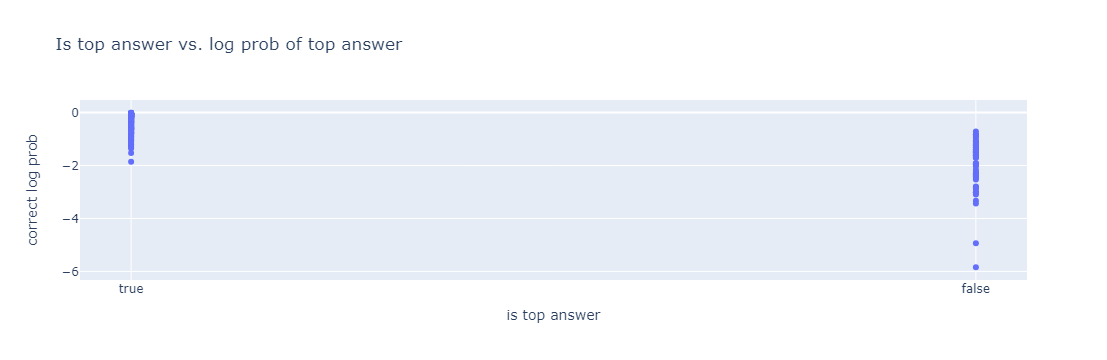

In [122]:


is_top_answer = (log_probs[:, -1, :].argmax(dim=-1) == answer_tokens)
px.scatter(x=is_top_answer.cpu(), y=plps, title="Is top answer vs. log prob of top answer",
           labels=dict(x="is top answer", y="correct log prob")
          )


In [194]:
print(f"accuracy: {sum(is_top_answer>0)/len(is_top_answer)}")

accuracy: 0.7578125


# Residual Stream Patching

In [123]:
answer_tokens_filt

NameError: name 'answer_tokens_filt' is not defined

In [ ]:
# Residual Stream Patching
clean_tokens = tokens_filt.clone()
clean_logits, clean_cache = model.run_with_cache(clean_tokens)
clean_answer = answer_tokens_filt.clone()
torch.manual_seed(SEED)